In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from utils import *
import sys
sys.path.append("/home/ubuntu/vdp-tool-chain-repo/utils")
from common import pz_partition
from train_clevr import VAE
from train_puzzles import PrototypeVAE
import itertools
from tqdm.auto import tqdm
device = torch.device("cuda:0")
sns.set()

In [2]:
train_on = list(filter(lambda x: not x[1] , pz_partition.keys()))
images = VDPImage("../data/clevr-cleaned-variants", to_run)
# training_idxs = list(itertools.chain(*[list(range(l, h + 1)) for l, h in map(lambda x : pz_partition[x], train_on)]))
training_idxs = list(range(0, 825))
allpuzzles = torch.utils.data.Subset(images, training_idxs)
allpuzzles = DataLoader(allpuzzles, batch_size=1)



In [3]:
# set([os.path.basename(os.path.dirname(pth[0])) for (x, y, pth) in (allpuzzles)])


In [5]:
height = 320
model_str = f"cifar-puzzle-prototype-net-{height}-final"
model_vae = VAE(height).from_pretrained("cifar10-resnet18")
# model_vae = model_vae.load_from_checkpoint(f"../data/prototype/puzzle-pretrained-vae-320-final.ckpt", strict=False, input_height=height)
model = PrototypeVAE(model_vae)
model = model.load_from_checkpoint(f"../data/prototype/{model_str}.ckpt", strict=False, vae_model=model_vae)
model = model.to(device)

In [6]:
preds = list()
tqdmiter = tqdm(allpuzzles)
for (x, y, pth) in tqdmiter:
    pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
    preds.append((pth, y[0][pred.item()] == 0. ))
    # preds.append((pth, torch.Tensor([True]) ))
    tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], preds) ) / len(preds)}")

sum(map(lambda x: x[1], preds) ) / len(preds)

  0%|          | 0/825 [00:00<?, ?it/s]

In [6]:
cleaned_preds = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), x[0], y.item()) for (x, y) in preds]
with open(f"{model_str}-results.pkl", "wb") as fp:
    pickle.dump(cleaned_preds, fp)

df = pd.DataFrame(cleaned_preds, columns=['puzzle_name', 'variant', 'pth', 'is_correct'])
df['pth'] = df['pth'].str.replace("../data", "data")

df

/home/ubuntu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,puzzle_name,variant,pth,is_correct
0,agreement,fovariant-0,data/clevr-cleaned-variants/agreement/fovariant-0,1.0
1,agreement,fovariant-1,data/clevr-cleaned-variants/agreement/fovariant-1,1.0
2,agreement,fovariant-10,data/clevr-cleaned-variants/agreement/fovarian...,1.0
3,agreement,fovariant-11,data/clevr-cleaned-variants/agreement/fovarian...,1.0
4,agreement,fovariant-12,data/clevr-cleaned-variants/agreement/fovarian...,1.0
...,...,...,...,...
820,train,fovariant-5-swap3,data/clevr-cleaned-variants/train/fovariant-5-...,1.0
821,train,fovariant-6-swap3,data/clevr-cleaned-variants/train/fovariant-6-...,1.0
822,train,fovariant-7-swap3,data/clevr-cleaned-variants/train/fovariant-7-...,1.0
823,train,fovariant-8-swap3,data/clevr-cleaned-variants/train/fovariant-8-...,1.0


In [7]:
with open("baseline_solver_preds.pkl", "rb") as fp:
    baseline_solver_preds = pickle.load(fp)
bs_df = pd.DataFrame(baseline_solver_preds, columns=["puzzle_name", "variant", "pth", "baseline", "solver"])
bs_df['baseline'] = (bs_df['baseline'] == 0)
bs_df['solver'] = (bs_df['solver'] == 0)

In [33]:
results = df.merge(bs_df, on='pth')

# all(results['puzzle_name_x'] == results['puzzle_name_y']), all(results['variant_x'] == results['variant_y'])

results['count'] = results.groupby(['puzzle_name_x'])['variant_x'].transform("count")
results['xlabel'] = results.apply(lambda row: f"{row['puzzle_name_x']}\n(N={row['count']})", axis=1)

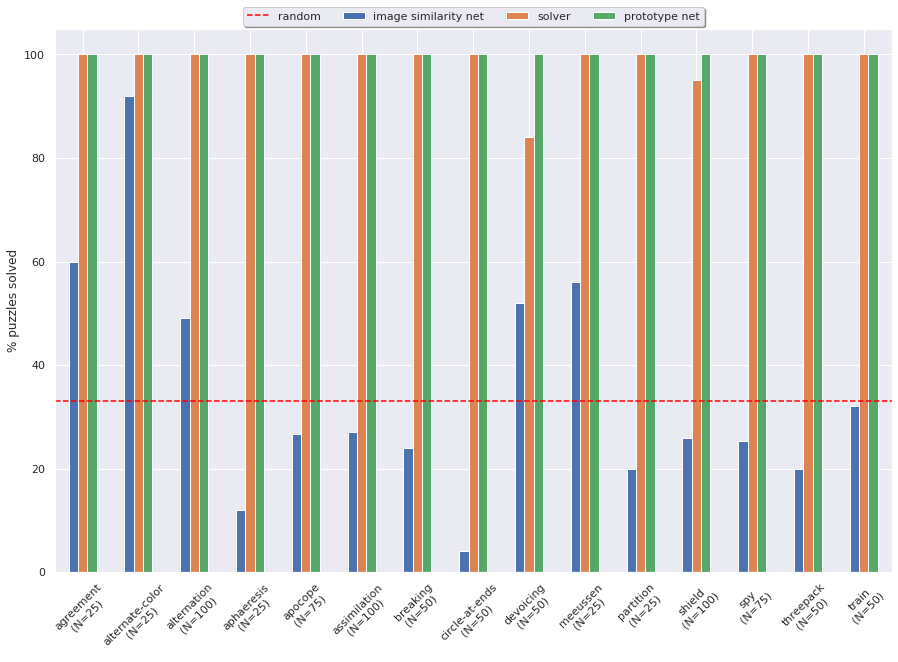

In [36]:
result = results[['xlabel', 'variant_x', 'baseline', 'solver', 'is_correct']].rename(columns={
                                                                                    'xlabel':'puzzle_name',
                                                                                    'variant_x':'variant',
                                                                                    'is_correct':'prototype net',
                                                                                    'baseline':'image similarity net',
                                                                                    'solver':'solver',
})


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

(result.groupby(['puzzle_name']).mean() * 100) .plot.bar(ax=ax)
ax.axhline(33, linestyle='--', label="random", color='red')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)

plt.xticks(rotation=45, ha='center')

plt.xlabel(None)
plt.ylabel("% puzzles solved")
plt.show()